## Najdaljši Hamiltonov cikel brez presečišč
Nastavitve začetnih pogojev za celoštevilski linearni program.

### Generiranje naključnih točk
Najprej generiramo naključnih n točk v ravnini s pomočjo funkcije generate_random_points, ki vrne seznam točkami v prostoru $[0,10)\times[0,10)$.

In [318]:
def generate_random_points(n, max_x = 10, max_y = 10):
    return [(max_x * random(), max_y * random()) for _ in range(n)]

Izberemo n točk:
[(1.1979519595329158, 2.070411138398468), (6.384027228797311, 6.254660971141842), (9.082692557906864, 5.317334221323996), (4.6678194275052345, 8.104309438877731), (4.892523043846736, 8.518832205467149), (7.738117362577307, 0.39492897505044033)]


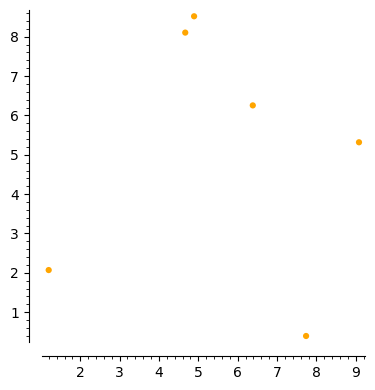

In [319]:
# Poizkus funckije in izris točk
print("Izberemo n točk:")
n = 6
list_points = generate_random_points(n)
print(list_points)

plot_points = list_plot(list_points, color = "orange", pointsize = 20)
show(plot_points, aspect_ratio=1)

### Razdalje med točkam
S pomočjo funkcije distance naredimo seznam, ki vsebuje razdalje med vsemi generiranimi točkami.

In [320]:
def distance(p, q):
    return math.sqrt((p[0] - q[0])^2 + (p[1] - q[1])^2)

In [321]:
# Poizkus funkcije na zgoraj generiranih točkah

# Indeksiramo razdalje med vsemi vozlišči
distances = {Set([i, j]): distance(list_points[i], list_points[j])
             for i in range(len(list_points)) for j in range(i+1, len(list_points))}

### Presečišča segmentov
Funckija preveri ali se dva segmenta sekata. S pomočjo te funkcije bomo naredili matriko presečišč.

In [322]:
# Funkcija orientation pove kakšna je orientacija med tremi točkami
# Orientacija med tremi točkami je lahko 0 če točke kolinearne, 
# 1 če so točke v smeri urinega kazalca ali 
# -1 če so točke v nasprotni smeri urinega kazalca

def orientation(p, q, r):

    val = ((q[1] - p[1]) * (r[0] - q[0])) - ((q[0] - p[0]) * (r[1] - q[1]))
    
    if val == 0 : 
        return 0
    elif val > 0:
        return 1
    else:
        return -1

# Funckija on_segment preveri ali se točka r nahaja na daljici med točkama p in q
# Vrne True če to drži oz. False če to ne drži

def on_segment(p, q, r):

    # r[0] je v intervalu (min(p[0], q[0]), max(p[0], q[0])) in
    # r[1] je v intervalu (min(p[1], q[1]), max(p[1], q[1]))

    if r[0] <= max(p[0], q[0]) and r[0] >= min(p[0], q[0]) and r[1] <= max(p[1], q[1]) and r[1] >= min(p[1], q[1]):
        return True
    return False

# Funckija intersects preveri ali se dva segmenta sekata
# Vrne True če to drži oz. False če to ne drži

def intersects(seg1, seg2):

    # seg1 = (p1, p2) = ((p1[0], p1[1]), ((p2[0], p2[1]))
    # seg2 = (p3, p4) = ((p3[0], p3[1]), ((p4[0], p4[1]))
    
    p1, q1 = seg1
    p2, q2 = seg2
    
    if p1 == p2:
        return False
    elif p1 == q2:
        return False
    elif q1 == p2:
        return False
    elif q1 == q2:
        return False
    
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    # primer
    # (p1, q1, p2) and (p1, q1, q2) have different orientations and
    # (p2, q2, p1) and (p2, q2, p2) have different orientations
    
    if o1 != o2 and o3 != o4:
        return True
    
    # primer
    # (p1, q1, p2), (p1, q1, q2), (p2, q2, p1), (p2, q2, p2) are all collinear and
    # the x-projections of (p1, q1) and (p2, q2) intersect and
    # the y-projections of (p1, q1) and (p2, q2) intersect
    
    if o1 == 0 and on_segment(p1, q1, p2) : return True
    if o2 == 0 and on_segment(p1, q1, q2) : return True
    if o3 == 0 and on_segment(p2, q2, p1) : return True
    if o4 == 0 and on_segment(p2, q2, q1) : return True

    
    return False
    

In [323]:
# Izpis matrike ki nam pove ali se dve daljici sekata med saboj.
# Če se daljici seg1 in seg2 na točkah p1, p2 in p3, p4 sekata 
# potem je vrednost v matriki 1, sicer je 0.

intersection = [] # seznam, ki pove katere povezave med vsemi vozlišči se sekajo med saboj
it = iter(distances) # iterator gre skozi ključe slovarja distances - to so ravno povezave grafa

for e in it: # za vsako povezavo
    
    seg1 = [list_points[i] for i in e]
    jt = copy(it) # kopija iteratorja - da se obravnava vsak par povezav enkrat
    
    for f in jt:
        seg2 = [list_points[i] for i in f]
        if intersects(seg1, seg2):
            intersection.append((e, f))

### Celoštevilski linearni program

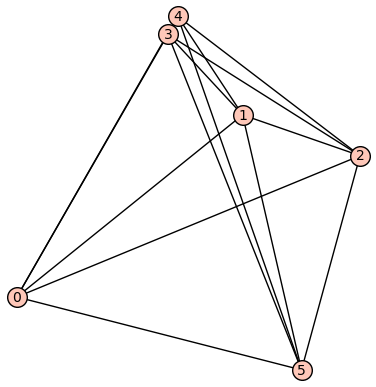

In [324]:
# Izris celotnega grafa
g = graphs.CompleteGraph(len(list_points))
g._pos = dict(enumerate(list_points))
g.plot()

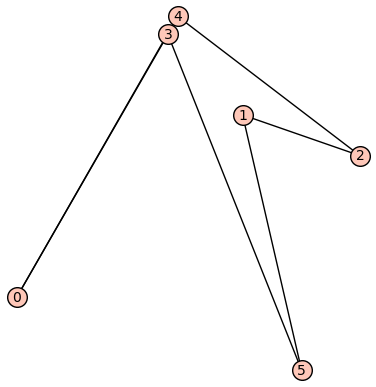

In [325]:
# Linearni program 1
# Maksimizacija vsote dolžin uporabljenih povezav.

p = MixedIntegerLinearProgram()
x = p.new_variable(binary=True)

# ciljna funkcija: max skupna dolžina uporabljenih povezav
p.set_objective(sum(x[e] * d for e, d in distances.items())) 

# POGOJI

# Če se povezavi sekata, smemo uporabiti največ eno
for e, f in intersection:
    p.add_constraint(x[e] + x[f] <= 1)

# Vsota vseh povezav v vozlišču je enaka 2  
for v in g.vertices():
    edges = g.edges_incident(v, labels = False)
    p.add_constraint(sum(x[Set(e)] for e in edges) == 2)

p.solve()

# Za določene particije množic vozlišč na dve neprazni množici obstajata 
# vsaj dve povezavi med tema množicama.
while True:
    
    x_sol = p.get_values(x)
    edges = [tuple(e) for e, i in x_sol.items() if i == 1]

    g_tmp = g.subgraph(vertices = g.vertices(), edges = edges)
    cc = g_tmp.connected_components()
    
    if len(cc) == 1:
        break
        
    boundary = g.edge_boundary(cc[0], labels = False)
    
    p.add_constraint(sum([x[e] for e in boundary]) >= 2)
    p.solve()
    
value1 = p.solve()
solution1 = p.get_values(x)
g_tmp.plot()

In [326]:
print(value1)
print(solution1)

36.83475398458389
{{0, 1}: 0, {0, 2}: 0, {0, 3}: 1, {0, 4}: 1, {0, 5}: 0, {1, 2}: 1, {1, 3}: 0, {1, 4}: 0, {1, 5}: 1, {2, 3}: 0, {2, 4}: 1, {2, 5}: 0, {3, 4}: 0, {3, 5}: 1, {4, 5}: 0}


In [327]:
# Izpis najkrajše povezave v zgornjem ciklu
m = distances[max(distances)]
for k, v in solution1.items():
    if v == 1:
        m = min(m, distances[k])
print(m)

2.8568122084697927


In [328]:
# Linearni program 2
# Maksimizacija dolžine najkrajše uporabljene povezave

p = MixedIntegerLinearProgram()
x = p.new_variable(binary=True)

# ciljna funkcija: max skupna dolžina uporabljenih povezav
p.set_objective(sum(x[e] * d for e, d in distances.items())) 

# POGOJI
        
# Če se povezavi sekata, smemo uporabiti največ eno
for e, f in intersection:
    p.add_constraint(x[e] + x[f] <= 1)

# Vsota vseh povezav v vozlišču je enaka 2    
for v in g.vertices():
    edges = g.edges_incident(v, labels = False)
    p.add_constraint(sum(x[Set(e)] for e in edges) == 2)

# Maksimiziranje realne spremenljivke t, ki naj bo navzgor omejena 
# z dolžinami uporabljenih povezav.    
dmax = max(distances.values())
for e, d in distances.items():
    p.add_constraint(p['t'] <= d + (1 - x[e]) * dmax)
p.set_objective(p['t'])

p.solve()

# Za določene particije množic vozlišč na dve neprazni množici obstajata 
# vsaj dve povezavi med tema množicama.
while True:
    
    x_sol = p.get_values(x)
    edges = [tuple(e) for e, i in x_sol.items() if i == 1]
    g_tmp = g.subgraph(vertices = g.vertices(), edges = edges)
    cc = g_tmp.connected_components()
    
    if len(cc) == 1:
        break
        
    boundary = g.edge_boundary(cc[0], labels = False)
    
    p.add_constraint(sum([x[e] for e in boundary]) >= 2)
            
    p.solve()

value2 = p.solve()
solution2 = p.get_values(x)

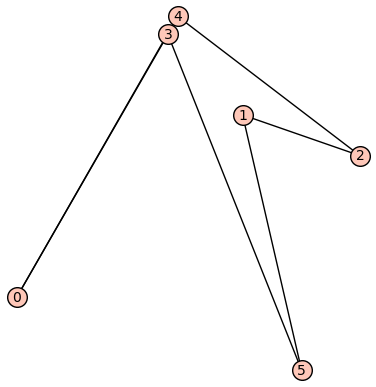

In [329]:
g_tmp.plot()

In [330]:
print(solution2, value2)

{{0, 1}: 0, {0, 2}: 0, {0, 3}: 1, {0, 4}: 1, {0, 5}: 0, {1, 2}: 1, {1, 3}: 0, {1, 4}: 0, {1, 5}: 1, {2, 3}: 0, {2, 4}: 1, {2, 5}: 0, {3, 4}: 0, {3, 5}: 1, {4, 5}: 0} 2.8568122084697922


In [331]:
# Izpis vsota dolžin uporabljeni povezav v zgornjem ciklu.
dolzina = 0
for k, v in solution2.items():
    if v == 1:
        dolzina += distances[k]

In [332]:
dolzina

36.83475398458389